<a href="https://colab.research.google.com/github/nbilasals/notebooks/blob/main/Gym_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Peak Logic Bouldering Hub: Multi Source Attendance Pipeline
## Automated ETL System for Consolidated Member Activity Reporting

### Project Overview
This pipeline consolidates disparate gym attendance and activity data from multiple acquired fitness studios into a unified Master Activity Log. The system handles:
1. Schema standardization across different source systems
2. Data quality validation and sanitization
3. Feature engineering for operational insights
4. Automated export for bussiness intelligence tools

**TARGET**: Repeatable, production-ready data transformation pipeline

## 1. Environment Setup

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [56]:
# Set professional styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 10

## 2. Simulate Multi-Source Data Scenario

In [57]:
print("PHASE 1: DATA INGESTION - SIMULATING MULTI-SOURCE SYSTEMS")

# Load the base gym dataset
df_raw = pd.read_csv("gym_members_exercise.csv")

print(f"Bae dataset loaded: {len(df_raw)} records")
print(f"Columns: {list(df_raw.columns)}")

PHASE 1: DATA INGESTION - SIMULATING MULTI-SOURCE SYSTEMS
Bae dataset loaded: 973 records
Columns: ['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned', 'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']


In [58]:
from datetime import timedelta

# Simulate 3 different source systems with varying schemas
# This mimics the real-world scenario of acquired studios with different tracking systems

# SOURCE 1: Main Peak Logic system (oriignal schema)
df_source1 = df_raw.iloc[:325].copy()
df_source1['Source_System'] = 'PeakLogic_Main'
df_source1['Member_ID'] = ['PL' + str(1000+i) for i in range(len(df_source1))]

# Add timestamp data (simulating check-in times)
np.random.seed(42)
base_data = datetime(2024,1,1)
df_source1['Check_In_Time'] = [
    base_data + timedelta(days=np.random.randint(0,180),
                          hours=np.random.randint(6,23),
                          minutes=np.random.randint(0,60))
    for _ in range(len(df_source1))
]

print(f"1. Peak Logic Main System")
print(f"  Records: {len(df_source1)}")
print(f"  Schema: Standard format with Member_ID, Check_In_Time")

1. Peak Logic Main System
  Records: 325
  Schema: Standard format with Member_ID, Check_In_Time


In [59]:
# SOURCE 2: Acquired Studio A (different column names)
df_source2 = df_raw.iloc[325:650].copy()
df_source2['Source_System'] = 'StudioA_Legacy'
df_source2['User_ID'] = ['SA' + str(2000+i) for i in range(len(df_source2))]

# Different timestamp format
df_source2['Timestamp'] = [
    base_data + timedelta(days=np.random.randint(0,180),
                          hours=np.random.randint(6,23),
                          minutes=np.random.randint(0,60))
    for _ in range(len(df_source2))
]

# Rename some columns to simulate schema mismatch
df_source2.rename(columns={
    'Session_Duration (hours)' : 'Duration_Hours',
    'Calories_Burned' : 'Cal_burnt',
    'Workout_Type': 'Activity_Type'
}, inplace=True)

print(f"Studio A Legacy System")
print(f"  Records: {len(df_source2)}")
print(f"  Schema: User_ID, Timestamp, Duration_Hours, Cal_burnt, Activity_Type")

Studio A Legacy System
  Records: 325
  Schema: User_ID, Timestamp, Duration_Hours, Cal_burnt, Activity_Type


In [60]:
# SOURCE 3: Acquired Studio B (another variation)
df_source3 = df_raw.iloc[650:].copy()
df_source3['Source_System '] = 'StudioB_System'
df_source3['Member_No'] = ['SB' + str(3000+i) for i in range(len(df_source3))]

# Different timestamp format
df_source3['Date_Time'] = [
    base_data + timedelta(days=np.random.randint(0,180),
                          hours=np.random.randint(6,23),
                          minutes=np.random.randint(0,60))
    for _ in range(len(df_source3))
]

# More column renames
df_source3.rename(columns={
    'Session_Duration (hours)' : 'Session_Hrs',
    'Calories_Burned' : 'Calories',
    'Workout_Type': 'Exercise_Type'
},inplace = True)

print(f" Studio B System")
print(f"  Records: {len(df_source3)}")
print(f"  Schema: Member_No, Date_Time, Session_Hrs, Calories, Exercise_Type")

 Studio B System
  Records: 323
  Schema: Member_No, Date_Time, Session_Hrs, Calories, Exercise_Type


In [61]:
# Introduce some data quality issues (realistic scenario)
print("INTRODUCING REALISTIC DATA QUALITY ISSUES")

# Add missing values in various columns
np.random.seed(42)
missing_indices_s2 = np.random.choice(df_source2.index, size=15, replace=False)
df_source2.loc[missing_indices_s2,'Duration_Hours'] = np.nan

missing_indices_s3 = np.random.choice(df_source3.index, size=20, replace=False)
df_source3.loc[missing_indices_s3,'Calories'] = np.nan

# Add some duplicate records
duplicates = df_source1.sample(5, random_state=42)
df_source1 = pd.concat([df_source1,duplicates],ignore_index=True)

print(" - Added missing values in Session Duration (15 records in Source 2)")
print(" - Added missing values in Calories (20 records in Source 3)")
print(" - Added duplicate records in Source 1 (5 records)")
print(f" Total raw records: {len(df_source1) + len(df_source2) + len(df_source3)}")

INTRODUCING REALISTIC DATA QUALITY ISSUES
 - Added missing values in Session Duration (15 records in Source 2)
 - Added missing values in Calories (20 records in Source 3)
 - Added duplicate records in Source 1 (5 records)
 Total raw records: 978


## 3. Schema Standardization Function

In [62]:
def standardize_schema(df, source_name):
  """
  Standardize column names and schema across different source systems.

  Args:
    df: DataFrame from source system
    source_name: Name of the source system

 Returns:
    DataFrame with standardized column names and schema
  """

  df_std = df.copy()

  # Define master schema mapping
  column_mappings = {
      # Member identification
      'Member_ID': 'member_id',
      'User_ID': 'member_id',
      'Member_No': 'member_id',
      # Timestamp standardization
      'Check_In_Time': 'session_timestamp',
      'Timestamp': 'session_timestamp',
      'Date_Time': 'session_timestamp',
      # Session Metrics
      'Session_Duration (hours)': 'session_duration_hours',
      'Duration_Hours': 'session_duration_hours',
      'Session_Hrs': 'session_duration_hours',
      # Calories
      'Calories_Burned':'calories_burned',
      'Cal_burnt': 'calories_burned',
      'Calories': 'calories_burned',
      # Workout
      'Workout_Type': 'workout_type',
      'Exercise_Type': 'workout_type',
      'Activity_Type': 'workout_type',
      # Demographics
      'Age': 'age',
      'Gender': 'gender',
      'Height (cm)': 'height_cm',
      'Weight (kg)': 'weight_kg',
      # Health metrics
      'Max_BPM': 'max_bpm',
      'Avg_BPM': 'avg_bpm',
      'Resting_BPM': 'resting_bpm',
      'Fat_Percentage': 'fat_percentage',
      'Water_Intake (liters)' : 'water_intake_liters',
      'BMI': 'bmi',
      #Experience
      'Workout_Frequency (days/week)' : 'workout_frequency_weekly',
      'Experience_Level': 'experience_level',
      #System info
      'Source_System': 'source_system'
  }
  for old_name, new_name in column_mappings.items():
      if old_name in df_std.columns:
            df_std.rename(columns={old_name: new_name},inplace= True)
  return df_std


In [63]:
# Apply standardization ro all sources
df_source1_std = standardize_schema(df_source1, 'PeakLogic_Main')
df_source2_std = standardize_schema(df_source2, 'StudioA_Legacy')
df_source3_std = standardize_schema(df_source3, 'StudioB_System')

# Combine all sources
df_combined = pd.concat([df_source1_std, df_source2_std, df_source3_std], ignore_index=True)

df_combined


,age,gender,weight_kg,Height (m),max_bpm,avg_bpm,resting_bpm,session_duration_hours,calories_burned,workout_type,fat_percentage,water_intake_liters,workout_frequency_weekly,experience_level,bmi,source_system,member_id,session_timestamp,Source_System
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20,PeakLogic_Main,PL1000,2024-04-12 20:42:00,NaN
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00,PeakLogic_Main,PL1001,2024-03-12 12:57:00,NaN
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71,PeakLogic_Main,PL1002,2024-03-15 16:23:00,NaN
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41,PeakLogic_Main,PL1003,2024-04-26 09:39:00,NaN
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39,PeakLogic_Main,PL1004,2024-05-31 08:21:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77,NaN,SB3318,2024-05-31 14:35:00,StudioB_System
974,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69,NaN,SB3319,2024-03-25 13:54:00,StudioB_System
975,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50,NaN,SB3320,2024-05-16 20:14:00,StudioB_System
976,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74,NaN,SB3321,2024-06-24 19:39:00,StudioB_System


In [64]:
print(f"Combiner dataset created: {len(df_combined)} total records")
print(f"Standardized columns: {len(df_combined.columns)}")

Combiner dataset created: 978 total records
Standardized columns: 19


## Data Quality Assesment Before Cleaning

In [65]:
print('PHASE  3: DATA QUALITY (BEFORE ASSESMENT)')

print('\nMissing Values Analysis: ')

missing_before = df_combined.isnull().sum()
missing_before_pct = (missing_before / len(df_combined)) * 100
missing_summary_before = pd.DataFrame({
    'Missing_Count': missing_before,
    'Missing_Percentage': missing_before_pct
})

missing_summary_before = missing_summary_before[missing_summary_before['Missing_Count'] > 0].sort_values(by='Missing_Percentage', ascending=False)

print(missing_summary_before)

PHASE  3: DATA QUALITY (BEFORE ASSESMENT)

Missing Values Analysis: 
                        Missing_Count  Missing_Percentage
Source_System                     655           66.973415
source_system                     323           33.026585
calories_burned                    20            2.044990
session_duration_hours             15            1.533742


In [66]:
print("Duplicates Records: ")
duplicates_count = df_combined.duplicated(subset=['member_id','session_timestamp']).sum()
print(f"Total duplicates: {duplicates_count}")

Duplicates Records: 
Total duplicates: 5


In [67]:
print("Data Type Analysis: ")
print("\nColumn Data Types:")
df_combined.dtypes

Data Type Analysis: 

Column Data Types:


,0
age,int64
gender,object
weight_kg,float64
Height (m),float64
max_bpm,int64
avg_bpm,int64
resting_bpm,int64
session_duration_hours,float64
calories_burned,float64
workout_type,object


## Data Sanization and Cleaning

In [68]:
print("PHASE 4: DATA CLEANING AND SANITIZATION")

df_clean = df_combined.copy()

# 5.1 Remove duplicates
print("\n Step 1: Removing duplicate records....")
initial_count = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=['member_id','session_timestamp'], keep='first')
print(f" - Removed {initial_count - len(df_clean)} duplicate records")
print(f"-  Total records after deduplication: {len(df_clean)}")

# 5.2 Handle Missing Values in session_duration_hours
print("\n Step 2: Handling missing values in session_duration_hours")
missing_duration = df_clean['session_duration_hours'].isnull().sum()
if missing_duration > 0 :
  # Impute with nedian duration by workout type
  df_clean['session_duration_hours'] = df_clean.groupby('workout_type')['session_duration_hours'].transform(lambda x: x.fillna(x.median()))
  print(f" - Imputed {missing_duration} missing values with median duration by workout type")
else:
  print(" - No missing values in session_duration_hours")


# 5.3 Handle missing values in calories_burned
print("\n Step 3: Handling missing values in calories_burned")
missing_calories = df_clean['calories_burned'].isnull().sum()
if missing_calories > 0:
  # Impute with median calories by workout type
  df_clean['calories_burned'] = df_clean.groupby('workout_type')['calories_burned'].transform(lambda x: x.fillna(x.median()))
  print(f" - Imputed {missing_calories} missing values with median calories by workout type")
else:
  print(" - No missing values in calories_burned")

# Handle missing values in Source_Syste and source_system
df_clean['source_system'] = df_clean['source_system'].fillna('Unknown')
print(" - Filled missing values in source_system with 'Unknown'")


# 5.4 Standardize timestamp format to ISO-8601
print("\n Step 4: Standardizing timestamp format to ISO-8601")
df_clean['session_timestamp'] = pd.to_datetime(df_clean['session_timestamp']).dt.tz_localize(None)
print(" - Timestamps standardized to ISO-8601 format")

# 5.5 Extract date and time components for analysis
print("\n Step 5: Extracting date and time components for analysis")
df_clean['session_date'] = df_clean['session_timestamp'].dt.date
df_clean['session_hour'] = df_clean['session_timestamp'].dt.hour
df_clean['session_dayofweek'] = df_clean['session_timestamp'].dt.dayofweek
df_clean['session_month'] = df_clean['session_timestamp'].dt.month
print(" - Date and time components extracted for analysis")

PHASE 4: DATA CLEANING AND SANITIZATION

 Step 1: Removing duplicate records....
 - Removed 5 duplicate records
-  Total records after deduplication: 973

 Step 2: Handling missing values in session_duration_hours
 - Imputed 15 missing values with median duration by workout type

 Step 3: Handling missing values in calories_burned
 - Imputed 20 missing values with median calories by workout type
 - Filled missing values in source_system with 'Unknown'

 Step 4: Standardizing timestamp format to ISO-8601
 - Timestamps standardized to ISO-8601 format

 Step 5: Extracting date and time components for analysis
 - Date and time components extracted for analysis


## 6. Feature Engineering

In [69]:
# 6.1 Peak Hour Indicator
print("Feature 1: Calculating Peak Hour Indicator ")
df_clean['is_peak_hour'] = df_clean['session_hour'].between(17,20).astype(int)
peak_count = df_clean['is_peak_hour'].sum()
peak_pct = (peak_count / len(df_clean)) * 100
print(f" - Calculated {peak_count} peak hours ({peak_pct:.2f}%)")
print(f" - Off-peak sessions: {len(df_clean) - peak_count} ({100-peak_pct:.1f}%)")

# 6.2 Session Load Category
print("\nFeature 2: Calculating Session Load Category")
df_clean['intensity_category'] = pd.cut(
    df_clean['calories_burned'],
    bins=[0,600,900,1200,float('inf')]
)

print(" - Intensity categories created based on calories burned")
print(df_clean['intensity_category'].value_counts().sort_index())

# 6.3 Weekend vs Weekday
print("\nFeature 3: Calculating Weekend vs Weekday")
df_clean['is_weekend'] = df_clean['session_dayofweek'].isin([5,6]).astype(int)
weekend_count = df_clean['is_weekend'].sum()
weekend_pct = (weekend_count / len(df_clean)) * 100
print(f" - Calculated {weekend_count} weekend sessions ({weekend_pct:.2f}%)")

Feature 1: Calculating Peak Hour Indicator 
 - Calculated 240 peak hours (24.67%)
 - Off-peak sessions: 733 (75.3%)

Feature 2: Calculating Session Load Category
 - Intensity categories created based on calories burned
intensity_category
(0.0, 600.0]       128
(600.0, 900.0]     372
(900.0, 1200.0]    344
(1200.0, inf]      129
Name: count, dtype: int64

Feature 3: Calculating Weekend vs Weekday
 - Calculated 268 weekend sessions (27.54%)


## 7. Data Quality Assesment (After Cleaning)


In [70]:
print("PHASE 6: DATA QUALITY ASSESSMENT (AFTER CLEANING)")
print("="*80)

print("\n" + "-"*80)
print("MISSING VALUES ANALYSIS:")
print("-"*80)
missing_after = df_clean.isnull().sum()
missing_after_pct = (missing_after / len(df_clean) * 100).round(2)
missing_summary_after = pd.DataFrame({
    'Missing_Count': missing_after,
    'Percentage': missing_after_pct
})
missing_summary_after = missing_summary_after[missing_summary_after['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_summary_after) > 0:
    print(missing_summary_after)
else:
    print("✓ No missing values in critical columns!")

print("\n" + "-"*80)
print("DATA COMPLETENESS:")
print("-"*80)
print(f"✓ Total cleaned records: {len(df_clean)}")
print(f"✓ Records removed: {len(df_combined) - len(df_clean)}")
print


PHASE 6: DATA QUALITY ASSESSMENT (AFTER CLEANING)

--------------------------------------------------------------------------------
MISSING VALUES ANALYSIS:
--------------------------------------------------------------------------------
                Missing_Count  Percentage
Source_System             650        66.8

--------------------------------------------------------------------------------
DATA COMPLETENESS:
--------------------------------------------------------------------------------
✓ Total cleaned records: 973
✓ Records removed: 5


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

## Visualization: Before vs After


PHASE 7: DATA QUALITY VISUALIZATION


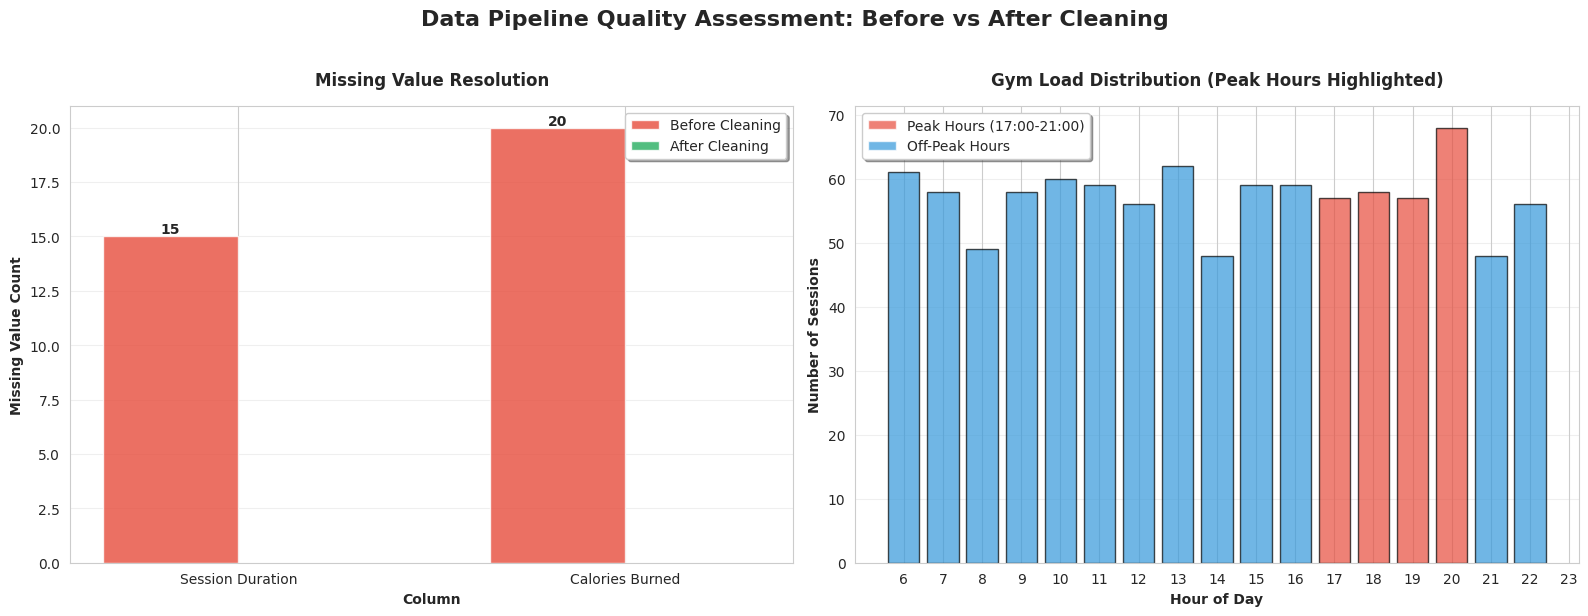


✓ Visualization saved: data_quality_before_after.png


In [71]:
print("PHASE 7: DATA QUALITY VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Data Pipeline Quality Assessment: Before vs After Cleaning',
             fontsize=16, fontweight='bold', y=1.02)

# Left: Missing values comparison
ax1 = axes[0]
missing_comparison = pd.DataFrame({
    'Before': missing_before[['session_duration_hours', 'calories_burned']],
    'After': missing_after[['session_duration_hours', 'calories_burned']]
})

x = np.arange(len(missing_comparison))
width = 0.35
bars1 = ax1.bar(x - width/2, missing_comparison['Before'], width,
                label='Before Cleaning', color='#E74C3C', alpha=0.8)
bars2 = ax1.bar(x + width/2, missing_comparison['After'], width,
                label='After Cleaning', color='#27AE60', alpha=0.8)

ax1.set_xlabel('Column', fontweight='bold')
ax1.set_ylabel('Missing Value Count', fontweight='bold')
ax1.set_title('Missing Value Resolution', fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(['Session Duration', 'Calories Burned'])
ax1.legend(frameon=True, fancybox=True, shadow=True)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Right: Gym load distribution by hour
ax2 = axes[1]
hourly_load = df_clean.groupby('session_hour').size()
colors = ['#E74C3C' if hour in range(17, 21) else '#3498DB' for hour in hourly_load.index]

bars = ax2.bar(hourly_load.index, hourly_load.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax2.set_xlabel('Hour of Day', fontweight='bold')
ax2.set_ylabel('Number of Sessions', fontweight='bold')
ax2.set_title('Gym Load Distribution (Peak Hours Highlighted)', fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticks(range(6, 24))

# Add peak hours legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#E74C3C', alpha=0.7, label='Peak Hours (17:00-21:00)'),
    Patch(facecolor='#3498DB', alpha=0.7, label='Off-Peak Hours')
]
ax2.legend(handles=legend_elements, loc='upper left', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('data_quality_before_after.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: data_quality_before_after.png")


## 10. Master Activity Log Export

In [73]:
print("\n" + "="*80)
print("PHASE 9: MASTER ACTIVITY LOG EXPORT")
print("="*80)

df_master = df_clean.copy()

# Sort by timestamp
df_master = df_master.sort_values(['session_date', 'session_hour']).reset_index(drop=True)

# Export to CSV
output_filename = 'master_activity_log.csv'
df_master.to_csv(output_filename, index=False)

print(f"\n✓ Master Activity Log exported: {output_filename}")
print(f"✓ Total records: {len(df_master):,}")
print(f"✓ Columns: {len(df_master.columns)}")
print(f"✓ Date range: {df_master['session_date'].min()} to {df_master['session_date'].max()}")



PHASE 9: MASTER ACTIVITY LOG EXPORT

✓ Master Activity Log exported: master_activity_log.csv
✓ Total records: 973
✓ Columns: 26
✓ Date range: 2024-01-01 to 2024-06-28
